## Dataset Overview
The Human Activity Recognition Trondheim (HARTH) dataset comprises recordings from 22 participants, each wearing two 3-axial Axivity AX3 accelerometers for approximately 2 hours in a free-living environment. The sensors, positioned on the right thigh and lower back, capture motion data essential for human activity recognition (HAR). This dataset's rich, professionally annotated data offers a comprehensive benchmark for developing advanced machine learning models aimed at precise HAR in real-world settings.

- Subject Area: Computer Science/Human Activity Recognition
- Dataset Characteristics: Multivariate, Time Series
- Associated Tasks: Classification
- Feature Type: Real-valued sensor data
- Sampling Rate: 50 Hz
- Annotations: Activities annotated frame-by-frame using video recordings from a chest-mounted camera
- Total Instances: 6,461,328
- Total Features: 8, including senesor readings (back_x, back_y, back_z, thigh_x, thigh_y, thigh_z)igh_z).

In [1]:
import io
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import seaborn as sns
import tensorflow as tf
import zipfile
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error as mse
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
from scipy import stats
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout, Flatten, TimeDistributed
from keras.models import Sequential
from keras.layers import TimeDistributed, Conv1D, MaxPooling1D, Flatten, LSTM, Dense, Dropout, BatchNormalization, Bidirectional
from keras.optimizers import Adam
from keras.optimizers.schedules import ExponentialDecay
from keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout, Flatten, Input, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

## Load the Dataset

In [ ]:
# URL for UCI data
zip_file_url = "https://archive.ics.uci.edu/static/public/779/harth.zip"
files = [
    'S029.csv', 'S028.csv', 'S027.csv', 'S026.csv', 'S025.csv',
    'S024.csv', 'S023.csv', 'S022.csv', 'S021.csv', 'S020.csv',
    'S019.csv', 'S018.csv', 'S017.csv', 'S016.csv', 'S015.csv',
    'S014.csv', 'S013.csv', 'S012.csv', 'S010.csv', 'S009.csv',
    'S008.csv', 'S006.csv',
]
data_types = {
    'back_x': 'float64', 'back_y': 'float64', 'back_z': 'float64',
    'thigh_x': 'float64', 'thigh_y': 'float64', 'thigh_z': 'float64',
    'label': 'int32'
}

dataframes = []
response = requests.get(zip_file_url)
with zipfile.ZipFile(io.BytesIO(response.content)) as zip_file:
    for file_name in files:
        with zip_file.open('harth/' + file_name) as csv_file:
            df = pd.read_csv(csv_file, dtype=data_types, header=0)
            print(f"Loaded {file_name} with shape: {df.shape}")
            if df.empty:
                print(f"Warning: {file_name} is empty.")
            dataframes.append(df)

combined_df = pd.concat(dataframes, ignore_index=True)
print(f"Combined DataFrame shape: {combined_df.shape}")
if combined_df.empty:
    raise ValueError("The combined DataFrame is empty. Check if the files are being loaded correctly.")

## Add Metadata
Adding labels to the dataset for readability.


In [ ]:
activity_labels = {
    1: 'walking',
    2: 'running',
    3: 'shuffling',
    4: 'stairs (ascending)',
    5: 'stairs (descending)',
    6: 'standing',
    7: 'sitting',
    8: 'lying',
    13: 'cycling (sit)',
    14: 'cycling (stand)',
    130: 'cycling (sit, inactive)',
    140: 'cycling (stand, inactive)'
}
combined_df['label'] = combined_df['label'].map(activity_labels)

# Output activity labels
activity_labels

In [ ]:
combined_df[combined_df['label'] == ['sitting']]

## Initial Data Exploration

In [4]:
# Define the original 8 features
original_features = ['timestamp', 'back_x', 'back_y', 'back_z', 'thigh_x', 'thigh_y', 'thigh_z', 'label']

# Create a temporary DataFrame with only the original 8 features
temp_df = combined_df[original_features]

# Displaying DataFrame information for the temporary DataFrame
print('Data Info')
temp_df.info()

# Adding a visual separator for clarity
print('\nData Head')

# Displaying the first few rows of the temporary DataFrame
temp_df.head()

Data Info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6461328 entries, 0 to 6461327
Data columns (total 8 columns):
 #   Column     Dtype  
---  ------     -----  
 0   timestamp  object 
 1   back_x     float64
 2   back_y     float64
 3   back_z     float64
 4   thigh_x    float64
 5   thigh_y    float64
 6   thigh_z    float64
 7   label      object 
dtypes: float64(6), object(2)
memory usage: 394.4+ MB

Data Head


,timestamp,back_x,back_y,back_z,thigh_x,thigh_y,thigh_z,label
0,2019-01-12 00:00:00.000,-1.000000,-0.071289,-0.215332,-0.997070,-0.124268,0.142334,standing
1,2019-01-12 00:00:00.020,-1.000000,-0.084473,-0.210449,-0.964844,-0.107422,0.160645,standing
2,2019-01-12 00:00:00.040,-0.997559,-0.111328,-0.199219,-0.971191,-0.108887,0.170898,standing
3,2019-01-12 00:00:00.060,-1.006592,-0.139160,-0.209717,-0.986084,-0.112061,0.154297,standing
4,2019-01-12 00:00:00.080,-1.030029,-0.140137,-0.228760,-0.985840,-0.127441,0.155029,standing


## Data Preprocessing
Imputing missing values and performing initial data processing steps

In [5]:
# List of columns to drop
columns_to_drop = ['Unnamed: 0', 'index', 'back_x_rolling_mean', 'thigh_x_rolling_mean']

# Drop the columns
combined_df = combined_df.drop(columns=columns_to_drop, errors='ignore')

# Display missing values 
print("Missing values per column:")
print(combined_df.isnull().sum())

Missing values per column:
timestamp    0
back_x       0
back_y       0
back_z       0
thigh_x      0
thigh_y      0
thigh_z      0
label        0
dtype: int64


## LSTM Activity Predictions



Epoch 1/8


72690/72690 [==============================] - 317s 4ms/step - loss: 0.4163 - accuracy: 0.8667 - val_loss: 0.3779 - val_accuracy: 0.8775
Epoch 2/8
72690/72690 [==============================] - 312s 4ms/step - loss: 0.3704 - accuracy: 0.8787 - val_loss: 0.3655 - val_accuracy: 0.8804
Epoch 3/8
72690/72690 [==============================] - 312s 4ms/step - loss: 0.3616 - accuracy: 0.8809 - val_loss: 0.3587 - val_accuracy: 0.8818
Epoch 4/8
72690/72690 [==============================] - 304s 4ms/step - loss: 0.3564 - accuracy: 0.8822 - val_loss: 0.3558 - val_accuracy: 0.8823
Epoch 5/8
72690/72690 [==============================] - 315s 4ms/step - loss: 0.3529 - accuracy: 0.8831 - val_loss: 0.3542 - val_accuracy: 0.8824
Epoch 6/8
72690/72690 [==============================] - 313s 4ms/step - loss: 0.3503 - accuracy: 0.8837 - val_loss: 0.3504 - val_accuracy: 0.8831
Epoch 7/8
72690/72690 [==============================] - 307s 4ms/step - loss: 0.3483 - accuracy: 0.8842 - val_los

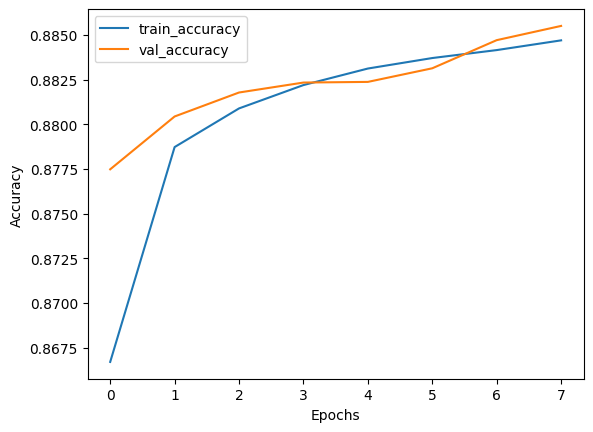

In [6]:
# Encode categorical labels
label_encoder = LabelEncoder()
combined_df['label_encoded'] = label_encoder.fit_transform(combined_df['label'])

# Define input features and target variable
X = combined_df[['back_x', 'back_y', 'back_z', 'thigh_x', 'thigh_y', 'thigh_z']].values
y = combined_df['label_encoded'].values

# Reshape the input features for LSTM
# LSTM input shape: [samples, time steps, features]
# Here, we assume each sample has 1 time step
X = X.reshape(X.shape[0], 1, X.shape[1])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the LSTM model
model = Sequential()
model.add(LSTM(units=64, input_shape=(X.shape[1], X.shape[2])))
model.add(Dense(64, activation='relu'))
model.add(Dense(len(label_encoder.classes_), activation='softmax'))

# Compile the model
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=8, batch_size=64, validation_split=0.1, verbose=1)

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}, Test Accuracy: {accuracy}')

# Summarize Training History for Accuracy
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

#Summarize Training History for Loss
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

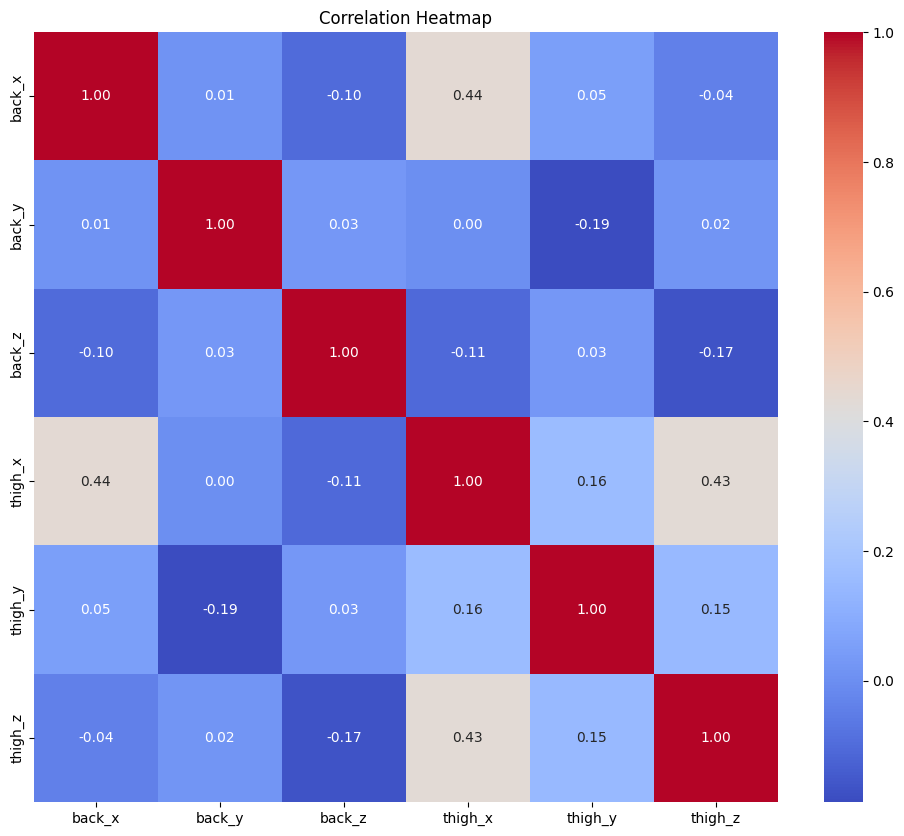

In [10]:
# Correlation Heatmap with explicit numeric_only parameter
plt.figure(figsize=(12, 10))
sensor_columns = ['back_x', 'back_y', 'back_z', 'thigh_x', 'thigh_y', 'thigh_z']
correlation_matrix = combined_df[sensor_columns].corr() 
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title('Correlation Heatmap')
plt.show()

In [11]:
combined_df.dtypes

timestamp         object
back_x           float64
back_y           float64
back_z           float64
thigh_x          float64
thigh_y          float64
thigh_z          float64
label             object
label_encoded      int32
dtype: object

## Outlier Detection and Removal

Removing outliers is crucial for preventing skewed analysis and improving model performance.

In [12]:
# Calculate Z-scores of the data
z_scores = np.abs(stats.zscore(combined_df.select_dtypes(include=[np.number])))

# Define the outlier threshold
outlier_threshold = 3

# Identify and remove outliers
outliers = (z_scores > outlier_threshold).any(axis=1)
combined_df_cleaned = combined_df[(z_scores < outlier_threshold).all(axis=1)]

# Display the shape of the DataFrame before and after outlier removal
print(f"DataFrame shape before outlier removal: {combined_df.shape}")
print(f"DataFrame shape after outlier removal: {combined_df_cleaned.shape}")

DataFrame shape before outlier removal: (6461328, 9)
DataFrame shape after outlier removal: (5953985, 9)


In [13]:
# Encode categorical labels
label_encoder = LabelEncoder()
combined_df_cleaned['label_encoded'] = label_encoder.fit_transform(combined_df_cleaned['label'])

# Define input features and target variable
X = combined_df_cleaned[['back_x', 'back_y', 'back_z', 'thigh_x', 'thigh_y', 'thigh_z']].values
y = combined_df_cleaned['label_encoded'].values

# Reshape the input features for LSTM
# LSTM input shape: [samples, time steps, features]
# Here, we assume each sample has 1 time step
X = X.reshape(X.shape[0], 1, X.shape[1])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the LSTM model
model = Sequential()
model.add(LSTM(units=64, input_shape=(X.shape[1], X.shape[2])))
model.add(Dense(64, activation='relu'))
model.add(Dense(len(label_encoder.classes_), activation='softmax'))

# Compile the model
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=8, batch_size=64, validation_split=0.1, verbose=1)

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}, Test Accuracy: {accuracy}')

# Summarize Training History
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Summarize Training History for Loss
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

C:\Users\sassy\AppData\Local\Temp\ipykernel_20312\3504424023.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combined_df_cleaned['label_encoded'] = label_encoder.fit_transform(combined_df_cleaned['label'])


Epoch 1/8
66983/66983 [==============================] - 307s 5ms/step - loss: 0.4393 - accuracy: 0.8585 - val_loss: 0.3982 - val_accuracy: 0.8704
Epoch 2/8
66983/66983 [==============================] - 381s 6ms/step - loss: 0.3895 - accuracy: 0.8717 - val_loss: 0.3816 - val_accuracy: 0.8734
Epoch 3/8
66983/66983 [==============================] - 396s 6ms/step - loss: 0.3784 - accuracy: 0.8744 - val_loss: 0.3705 - val_accuracy: 0.8768
Epoch 4/8
 5573/66983 [=>............................] - ETA: 6:05 - loss: 0.3723 - accuracy: 0.8756

KeyboardInterrupt: 

In [ ]:
# Correlation Heatmap with explicit numeric_only parameter
plt.figure(figsize=(12, 10))
sensor_columns = ['back_x', 'back_y', 'back_z', 'thigh_x', 'thigh_y', 'thigh_z']
correlation_matrix = combined_df_cleaned[sensor_columns].corr() 
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title('Correlation Heatmap')
plt.show()